# Задача "Кредитный скоринг" http://mlbootcamp.ru

In [91]:
import pandas
import numpy as np
import pylab as plt
import math
from pandas.plotting import scatter_matrix
%matplotlib inline

RAND = 228

In [92]:
def read_csv(data_name, result_name=None):
    data = pandas.read_csv(data_name, header=None, na_values='?')
    data.columns = [str(x) + '_class' for x in range(1, 16)]
    if result_name != None:
        train = pandas.read_csv(result_name, header=None)
        train.columns = ["answer"]
        return (data, train)
    return data

X_data, y_train = read_csv('data\crx_data_train_x.csv', 'data\crx_data_train_y.csv')

# выделения числовых и категориальных признаков
categoricals = [x for x in X_data.columns if X_data[x].dtype.name == 'object']
numericals   = [x for x in X_data.columns if X_data[x].dtype.name != 'object']

X_data.shape

(483, 15)

In [93]:
X_data[categoricals].describe()

,1_class,4_class,5_class,6_class,7_class,9_class,10_class,12_class,13_class
count,476,479,479,477,477,483,483,483,483
unique,2,3,3,14,8,2,2,2,3
top,b,u,g,c,v,t,f,f,g
freq,329,364,364,91,279,261,270,253,439


In [94]:
X_data[numericals].describe()

,2_class,3_class,8_class,11_class,14_class,15_class
count,476.000000,483.000000,483.000000,483.000000,477.000000,483.000000
mean,31.555462,4.796056,2.171170,2.387164,184.981132,951.000000
std,12.057072,5.116264,3.352241,4.352373,165.520244,4089.710922
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.647500,0.980000,0.165000,0.000000,80.000000,0.000000
50%,28.500000,2.750000,1.000000,0.000000,160.000000,6.000000
75%,38.250000,7.500000,2.500000,3.000000,280.000000,459.500000
max,80.250000,28.000000,28.500000,40.000000,1160.000000,51100.000000


In [95]:
# значения категориальных признаков
cat_value = {}

for x in categoricals:
    temp = X_data[x].unique()
    cat_value[x] = temp
    print(x, temp)

1_class ['b' 'a' nan]
4_class ['u' 'y' nan 'l']
5_class ['g' 'p' nan 'gg']
6_class ['k' 'w' 'i' 'c' 'q' 'm' 'd' 'cc' nan 'aa' 'x' 'e' 'ff' 'j' 'r']
7_class ['v' 'h' nan 'bb' 'ff' 'z' 'j' 'dd' 'n']
9_class ['f' 't']
10_class ['f' 't']
12_class ['t' 'f']
13_class ['g' 's' 'p']


In [96]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# fill nan values
class nan_filler:
    def __init_(self):
        self.__nan_values = None
        self.__describe = None
        
    def fit(self, data):
        self.__nan_values = data.mean(axis=0)
        self.__describe = data[categoricals].describe()
    
    def transform(self, data):
        data = data.fillna(self.__nan_values, axis=0)
        categoricals = [x for x in data.columns if data[x].dtype.name == 'object']
        for x in categoricals:
            data[x] = data[x].fillna(self.__describe[x]['top'])
        return data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
# scale data to standart
class my_scaler:
    def __init_(self):
        self.__scaler = None
        self.__num_columns = None
        
    def fit(self, data):
        self.__scaler = StandardScaler()
        self.__num_columns = data.select_dtypes(include=[np.number]).columns
        self.__scaler.fit(data[self.__num_columns])
    
    def transform(self, data):
        data = data.copy()
        data[self.__num_columns] = pandas.DataFrame(
            self.__scaler.transform(data[self.__num_columns]),
            columns=self.__num_columns
        )
        return data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

def log_transfom(data):
    data = data.copy()
    for x in [3, 8, 11, 15]:
        data[str(x) + '_class_log'] = np.log(1 + data[str(x) + '_class'])
        data.drop(str(x) + '_class', inplace=True, axis=1)
    return data
    
Nan_filler = nan_filler()
My_scaler = my_scaler()
X_train = Nan_filler.fit_transform(X_data)
# X_train = log_transfom(X_train)
X_train = My_scaler.fit_transform(X_train)
X_train.describe()

,2_class,3_class,8_class,11_class,14_class,15_class
count,4.830000e+02,4.830000e+02,4.830000e+02,4.830000e+02,4.830000e+02,4.830000e+02
mean,3.172066e-17,-1.471103e-17,3.677757e-18,3.965082e-17,4.873029e-17,7.688812e-17
std,1.001037e+00,1.001037e+00,1.001037e+00,1.001037e+00,1.001037e+00,1.001037e+00
min,-1.489149e+00,-9.383857e-01,-6.483487e-01,-5.490426e-01,-1.125762e+00,-2.327759e-01
25%,-7.431302e-01,-7.466410e-01,-5.990769e-01,-5.490426e-01,-6.388961e-01,-2.327759e-01
50%,-2.413239e-01,-4.003268e-01,-3.497315e-01,-5.490426e-01,-1.520306e-01,-2.313072e-01
75%,5.180764e-01,5.290477e-01,9.819437e-02,1.409511e-01,5.660959e-01,-1.203042e-01
max,4.072538e+00,4.540032e+00,7.862242e+00,8.650874e+00,5.933788e+00,1.227495e+01


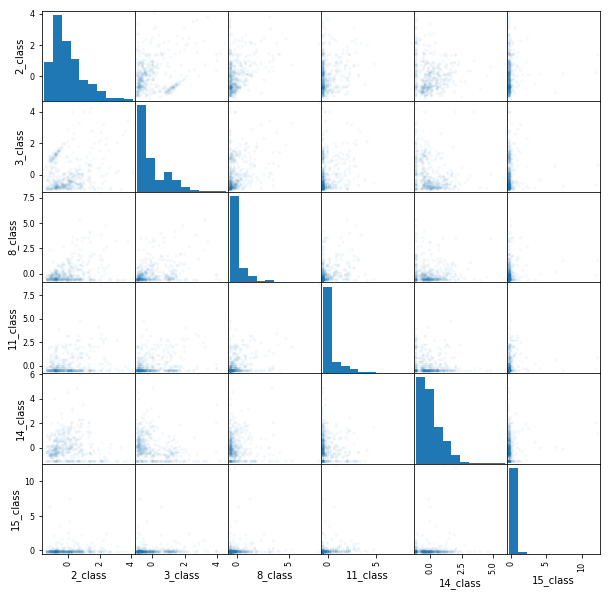

In [97]:
# Функция scatter_matrix позволяет построить для каждой количественной переменной гистограмму, 
# а для каждой пары таких переменных – диаграмму рассеяния

scatter_matrix(X_train, alpha=0.05, figsize=(10, 10));

Векторизация категориальных признаков

In [98]:
class my_transform:
    def __init_(self):
        self.__categoricals = None
        self.__numbers = None
        self.__data = None
    
    def fit(self, data):
        self.__categoricals = [x for x in data.columns if data[x].dtype.name == 'object']
        self.__numbers = [x for x in data.columns if data[x].dtype.name != 'object']
        self.__data = data
        
    def transform(self, data):
        categorical = self.__categoricals
        data = data.copy()
        for column in categorical:
            data[column] = data[column].astype('category', categories=self.__data[column].unique())
            
        binary = [x for x in categorical if len(self.__data[x].unique()) <= 2]
        other  = [x for x in categorical if len(self.__data[x].unique()) >  2]
        
        data_nobin = pandas.get_dummies(data[other])
        data_bin = data.drop(other, inplace=False, axis=1)
        for x in binary:  
            temp = self.__data[x].unique()
            data_bin = data_bin.replace({x: {y:2 * i - 1 for i, y in enumerate(temp)}}, inplace=False)
        return pandas.concat([data_bin, data_nobin], axis=1)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

My_transform = my_transform()
X_train_n = My_transform.fit_transform(X_train)

# Вспомогательные функции

In [ ]:
from sklearn.metrics import accuracy_score

def save(name, model, X_test):
    y_test = 1 - model.predict(X_test)
    result = pandas.DataFrame(y_test,)
    result.to_csv('{}.csv'.format(name), index=False, header=None)

def save_result(name, model):
    test_data = read_csv('data\crx_data_test_x.csv')
    test_data = Nan_filler.transform(test_data)
    # test_data = log_transfom(test_data)
    test_data = My_scaler.transform(test_data)
    test_data = My_transform.transform(test_data)
    
    save(name, model, test_data)
    
def cr_score(model, X, y):
    kfl = KFold(random_state=RAND, n_splits=3, shuffle=True)
    return mean(cross_val_score(model, X, y, cv=kfl, n_jobs=-1))

def base_train(name, model):
    model.fit(X_train_n.get_values(), np.ravel(y_train.get_values()))
    print(name + ' result: ', cr_score(model, X_train_n, y_train))
    save_result(name, model)


# LogisticRegression

C=0.001. Score=0.8303694158075601. Time elapsed: 0:00:06.259670
C=0.01. Score=0.8531786941580757. Time elapsed: 0:00:05.897225
C=0.1. Score=0.8531786941580755. Time elapsed: 0:00:06.212580
C=1.0. Score=0.8448668384879724. Time elapsed: 0:00:06.260330
C=10.0. Score=0.8407216494845361. Time elapsed: 0:00:06.108259
C=100.0. Score=0.8344931271477662. Time elapsed: 0:00:06.966447


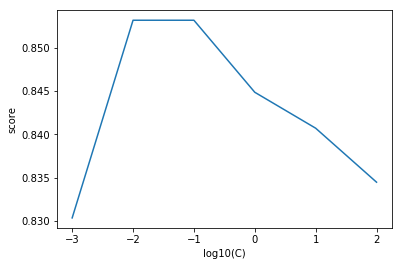

Наилучшее значение при C = 0.01


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
import time
import datetime
import matplotlib.pyplot as plt

def lr_score(X, y, C_grid):
    kfl = KFold(random_state=RAND, n_splits=5, shuffle=True)
    scores = []

    for C in C_grid:
        start_time = datetime.datetime.now()
        lg = LogisticRegression(C=C, random_state=RAND)

        score = mean(cross_val_score(lg, X, y, cv=kfl, scoring='accuracy', n_jobs=-1))
        scores.append(score)

        time = datetime.datetime.now() - start_time

        print('C={0}. Score={1}. Time elapsed: {2}'.format(
            C, 
            score, 
            time
        ))
    return scores


def lr_process(X, y):
    C_grid = np.power(10.0, np.arange(-3, 3))
    scores = lr_score(X, y, C_grid)
    
    plt.plot(np.log10(C_grid), scores)
    plt.xlabel('log10(C)')
    plt.ylabel('score')
    plt.show()
    
    return C_grid[np.argmax(scores)]
    
C_best = lr_process(X_train_n, y_train)
print('Наилучшее значение при C =', C_best)

In [100]:
lg = LogisticRegression(C=C_best, random_state=RAND)
base_train('lg', lg)

lg result:  0.853002070393


# SVC

In [101]:
from sklearn.svm import SVC

svc = SVC()
base_train('svc', svc)

svc result:  0.848861283644


# RANDOM FOREST

In [102]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=RAND)
base_train('rf', rf)

rf result:  0.859213250518


# GaussianNB

In [103]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
base_train('gnb', gnb)

gnb result:  0.706004140787


# KNeighborsClassifier

In [104]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
base_train('knn', knn)

knn result:  0.824016563147


# RidgeClassifier

In [107]:
from sklearn.linear_model import RidgeClassifier

rc = RidgeClassifier()
base_train('rc', rc)

rc result:  0.853002070393


# AdaBoostClassifier

In [113]:
from sklearn.ensemble import AdaBoostClassifier

adc = AdaBoostClassifier(n_estimators=100, learning_rate=0.3)
base_train('adc', adc)

adc result:  0.84265010352


## Объединение моделей

In [114]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('lr', lg), ('rf', rf), ('rc', rc), ('adc', adc)])
base_train('eclf', eclf)

eclf result:  0.867494824017
